<a href="https://colab.research.google.com/github/NeznaikanaLune/MISIS_DS_Masters_degree_2020/blob/master/ml_5_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Бустинг. Практика

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv',index_col=False)
# Из столбца yesno сделайте столбец spam, где 1 соответствует значению y (является спамом), 
# а 0 – n (не является спамом). Удалите первый столбец (с индексом) и столбец "yesno".
df['yesno'] = np.where(df['yesno']=='y',1,0)
X = df.drop(['yesno','Unnamed: 0'],axis=1)
Y = df['yesno']
# Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга.
memory = []
l = list(X.columns)
for i in X.columns:
    l.remove(i)
    for j in l:
      X[i+'_'+j] = X[i]*X[j]
    memory.append(i)

# Разделим получившиеся данные на обучающую и тестовую выборки в соотношении 80:20.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Обучите модель GradientBoostingClassifier (из библиотеки sklearn), используя параметры "по умолчанию" 
#(на момент создания урока это learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1, 
#max_features=None).
#Во всех методах, где присутствует случайность, укажите random_state=42.
#Это будет наш baseline. Укажите точность на тестовой выборке (параметр score), округлив до третьего знака после точки-разделителя.

clf = ensemble.GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8653637350705755


dollar_bang


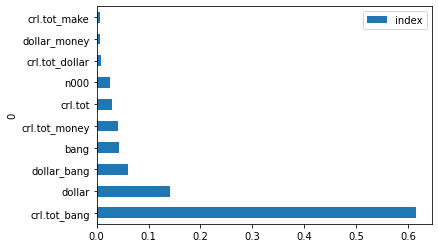

In [28]:
#Воспользуйтесь методом feature_importances_. С его помощью можно оценить вклад каждого признака в обучение модели. 
#Постройте столбчатую диаграмму так, чтобы по горизонтали были указаны названия признаков, а по вертикали их важность. 
#В ответе укажите третий по важности признак (без кавычек и пробелов).
feature_importances_frame = pd.DataFrame(list(X.columns),clf.feature_importances_).sort_index(ascending=False)
print(feature_importances_frame.reset_index().iloc[2,1])
feature_importances_frame.reset_index().set_index(0).iloc[:10].plot.barh();

In [32]:
#Теперь перейдем к подбору параметров в модели. Для этого в библиотеке scikit-learn есть метод GridSearchCV. 
#Ему на вход подается модель, список параметров и способ оценивания. 
#При запуске метода fit модель обучается со всеми возможными комбинациями параметров, 
#лучшей комбинацией параметров становится та, при которой значение метрики максимально.
#Укажите в качестве estimator градиетный бустинг с параметрами "по умолчанию" и random_state=42. 
#В параметре scoring укажите 'accuracy', n_jobs=-1, cv=5.

param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

clf = ensemble.GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.score(X_test, y_test))
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8610206297502715


In [34]:
grid_search.best_params_

{'learning_rate': 0.01, 'n_estimators': 1750}

In [36]:
# Теперь воспользуемся GridSearchCV для подбора максимальной глубины (max_depth). В качестве estimator используйте градиентный бустинг 
# с ранее подобранными параметрами и random_state=42. Переберите все значения max_depth от 5 до 15 включительно. 
# В ответ запишите значение параметра, при котором точность максимальна.

param_grid = {'max_depth':range(5,16)}

clf = ensemble.GradientBoostingClassifier(random_state=42,learning_rate= 0.01,n_estimators= 1750)
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.score(X_test, y_test))
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8653637350705755
0.8831521739130436
{'max_depth': 5}


**Алгоритм построение AdaBoost:**

1. Инициализируем веса объектов 
$w_j = \frac{1}{N}, \, j=1,2,\dots,N$
2. Для всех $i$ от 1 до T:

  1) Строим классификатор $b_{i}(x)$ , используя веса $w_{i}$.

  2) Вычисляем ошибку $err_i = \frac{\sum\limits_{j=1}^{N}w_j[y_j \neq b_i(x_j)]}{\sum\limits_{j=1}^{N}w_j}$

  3) Вычисляем вес нового алгоритма $c_i = \frac{1}{2} \log{\frac{1-err_i}{err_i}}$

  4) Получаем новые веса объектов $w_j \leftarrow w_j \cdot exp\left( c_i [y_j \neq b_i(x_j)]\right), \, j = 1, \dots, N.$

  5) Нормируем веса объектов $w_j \leftarrow \frac{w_j}{\sum\limits_{j=1}^{N}w_j}.$

3. Группируем полученные модели: $a_T(x) = sign\left[\sum\limits_{i=1}^{T}c_i b_i(x)\right]$    

In [61]:
# изучить код для реализации AdaBoost с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками 
# (вычисление ошибки и веса алгоритма) на всех признаках, получившихся после всех преобразований в предыдущем датасете 
#(до разделения выборки на обучающую и тестовую). Параметр learning_rate возьмите равным 0.001, М = 10. 
# В ответ запишите точность, округленную до трёх знаков после точки-разделителя.


def AdaBoost_scratch(X,y, M=10, learning_rate =1):
	# инициалиазция служебных переменных
	N = len(y)
	estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]
	
	# инициализация весов
	sample_weight = np.ones(N) / N
	sample_weight_list.append(sample_weight.copy())
	
	# цикл по длине М
	for m in range(M):

		# обучим базовую модель и получим предсказание
		estimator = tree.DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
		estimator.fit(X, y, sample_weight=sample_weight)
		y_predict = estimator.predict(X)
		
		# Маска для ошибок классификации
		incorrect = (y_predict != y)
		
		# Оцениваем ошибку
		estimator_error = sum(sample_weight*incorrect)/sum(sample_weight)
		# Вычисляем вес нового алгоритма
		estimator_weight =  0.5*np.log((1-estimator_error)/estimator_error)
	  
		sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))/sum(sample_weight)

		# Сохраяем результаты данной итерации
		estimator_list.append(estimator)
		y_predict_list.append(y_predict.copy())
		estimator_error_list.append(estimator_error)
		estimator_weight_list.append(estimator_weight.copy())
		sample_weight_list.append(sample_weight.copy())

	# Для удобства переведем в numpy.array
	estimator_list = np.asarray(estimator_list)
	y_predict_list = np.asarray(y_predict_list)
	estimator_error_list = np.asarray(estimator_error_list)
	estimator_weight_list = np.asarray(estimator_weight_list)
	sample_weight_list = np.asarray(sample_weight_list)

	# Получим предсказания
	
	preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
	print('Accuracy = ', accuracy_score(preds, y))

	return estimator_list, estimator_weight_list, sample_weight_list

Y = Y.replace({0:-1})
estimator_list, estimator_weight_list, sample_weight_list = AdaBoost_scratch(X, Y, M=10, learning_rate=0.001)

Accuracy =  0.8641599652249511


In [92]:
# изучить код для реализации AdaBoost с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками 
# (вычисление ошибки и веса алгоритма) на всех признаках, получившихся после всех преобразований в предыдущем датасете 
#(до разделения выборки на обучающую и тестовую). Параметр learning_rate возьмите равным 0.001, М = 10. 
# В ответ запишите точность, округленную до трёх знаков после точки-разделителя.

Y = Y.replace({0:-1})
M=10
learning_rate =1
	# инициалиазция служебных переменных
N = len(Y)
estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]
	
# инициализация весов
sample_weight = np.ones(N) / N
sample_weight_list.append(sample_weight.copy())
	
	# цикл по длине М
for m in range(M):

		# обучим базовую модель и получим предсказание
		estimator = tree.DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
		estimator.fit(X, Y, sample_weight=sample_weight)
		y_predict = estimator.predict(X)
		
		# Маска для ошибок классификации
		incorrect = (y_predict != Y)
		# print(incorrect)
		# Оцениваем ошибку
		estimator_error = sum(sample_weight*incorrect)/sum(sample_weight)
		# Вычисляем вес нового алгоритма
		estimator_weight =  0.5*np.log((1-estimator_error)/estimator_error)
		print(type((sample_weight > 0) | (estimator_weight < 0)))
		# print(incorrect )
		sample_weight *= np.exp(estimator_weight * incorrect )/sum(sample_weight) # новые веса или меняются с домножением на вес модели, или остаются прежними в зависимости от маски

		# Сохраяем результаты данной итерации
		estimator_list.append(estimator)
		y_predict_list.append(y_predict.copy())
		estimator_error_list.append(estimator_error)
		estimator_weight_list.append(estimator_weight.copy())
		sample_weight_list.append(sample_weight.copy())

# Для удобства переведем в numpy.array
estimator_list = np.asarray(estimator_list)
y_predict_list = np.asarray(y_predict_list)
estimator_error_list = np.asarray(estimator_error_list)
estimator_weight_list = np.asarray(estimator_weight_list)
sample_weight_list = np.asarray(sample_weight_list)

	# Получим предсказания
	
preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
print('Accuracy = ', accuracy_score(preds, Y))


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Accuracy =  0.8641599652249511


In [95]:
np.exp(pd.Series([False,False,False,False])*pd.Series([1,2,3,4]))

0    1.0
1    1.0
2    1.0
3    1.0
dtype: float64

# *Практика*

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [19]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    print(len(X_meta_train))
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [39]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', sep=',', header=None)[:10000]
print(df.shape)
features = list(range(0, 54))
target = 54

df = df[(df[target] == 1) | (df[target] == 2)]
cover_train, cover_test = train_test_split(df, test_size=0.5)

cover_X_train, cover_y_train = cover_train[features], cover_train[target]
cover_X_test, cover_y_test = cover_test[features], cover_test[target]
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(cover_X_train)
cover_X_test = scaler.transform(cover_X_test)
df.head(3)


(10000, 55)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
5,2579,132,6,300,-15,67,230,237,140,6031,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2


Stacking — еще один способ объединить несколько алгоритмов в один, который часто используется как в решении реальных задач из промышленной сферы, так и в конкурсах на платформах вроде Kaggle.
Подход использует понятие _базовых классификаторов_, каждый из которых независимо обучается на некотором (возможно одном и том же) множестве признаков, а также _мета-классификатора_, использующего предсказания базовых классификаторов как признаки.

Для избежания переобучения будем разбивать обучающую выборку на фолды.
Например, фолды при разбиении на три части:
==*
=*=
*==

Это требуется для того, чтобы получить новые признаки (ответы алгоритмов на первом уровне) на всей обучающей выборке, т.е. ответы алгоритма на тех объектах, которые не были использованы во время обучения. В примере выше мы будем использовать ответы алгоритма, полученные на объектах звездочках. _Важно_: на каждом фолде мы обучаем алгоритм заново.

In [7]:
np.random.seed(42)

clf = GradientBoostingClassifier(n_estimators=300)
clf.fit(cover_X_train, cover_y_train)

accuracy_score(clf.predict(cover_X_test), cover_y_test)

0.7730796335447498

In [20]:
cv = KFold(n_splits=10, shuffle=True)

stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=5000),
    LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=5000),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=300)
], cover_X_train, cover_X_test, cover_y_train.values, cv)

  0%|          | 0/4 [00:00<?, ?it/s]

1418
1418
1418


 75%|███████▌  | 3/4 [00:11<00:03,  3.81s/it]

1418


100%|██████████| 4/4 [00:25<00:00,  6.28s/it]


In [24]:
total_features_train = np.hstack([cover_X_train, stacked_features_train])
total_features_test = np.hstack([cover_X_test, stacked_features_test])
np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, cover_y_train)
accuracy_score(clf.predict(stacked_features_test), cover_y_test)

0.7942212825933757

# Задача

In [41]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

In [42]:
dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Мы разобрали схему генерации признаков в стекинге, когда для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке. Реализуйте схему, когда вместо этого производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения.

Логика решения:

1) Создадим X_meta_test, заполним его нулями (по аналогии с X_meta_train);

2) Далее на каждом шаге, где мы обучаем folded_clf.fit (X_fold_train, y_fold_train) и его предсказания на X_fold_predict запихиваем в X_meta_train[predict_fold_index] добавим еще одну строку, где в X_meta_test будем добавлять предсказания вероятностей folded_clf на X_test. Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить, а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);

3) После цикла останется только усреднить все эти массивы, это и будет наш X_meta_test.

In [31]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.     
    Они являются вероятностями классов при решении задачи многоклассовой классификации.    
    :arg clf: классификатор    
    :args X_train, y_train: обучающая выборка    
    :arg X_test: признаки тестовой выборки    
    :arg cv: класс, генерирующий фолды (KFold)    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    """

    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    X_meta_test = np.zeros((len(X_test), n_classes), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
        X_meta_test+= folded_clf.predict_proba(X_test)
    X_meta_test = X_meta_test/cv.n_splits

    return X_meta_train, X_meta_test

stacked_features_train, stacked_features_test = compute_meta_feature(GradientBoostingClassifier(n_estimators=300), cover_X_train, cover_X_test, cover_y_train.values, cv)

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000
логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000
случайный лес из 300 деревьев
градиентный бустинг из 200 деревьев
Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [47]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=2000,multi_class='ovr',random_state=42),
    LogisticRegression(C=0.001, penalty='l2', solver='saga', max_iter=2000,multi_class='multinomial',random_state=42),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1,random_state=42),
    GradientBoostingClassifier(n_estimators=200,random_state=42)
], X_train, X_test, y_train, cv)

np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs',multi_class='auto',random_state=42)
clf.fit(stacked_features_train, y_train)
accuracy_score(clf.predict(stacked_features_test), y_test)

compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test,y_test=y_test)


100%|██████████| 4/4 [02:28<00:00, 37.24s/it]


0.975579

При запуске в Juputer Notebook Windows10 PC f1= 0.978096. Именно этот ответ проходит грейдер на 15.12.2020
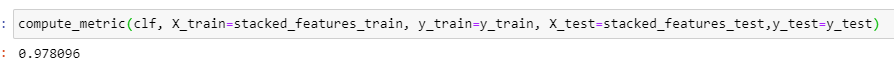


Используйте функцию generate_meta_features для стекинга следующих алгоритмов:

- случайный лес из 300 деревьев
- случайный лес из 200 экстремальных деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [54]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestClassifier(n_estimators=200, n_jobs=-1,random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=42)
], X_train, X_test, y_train, cv)

np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs',multi_class='auto',random_state=42)
clf.fit(stacked_features_train, y_train)
accuracy_score(clf.predict(stacked_features_test), y_test)

compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test,y_test=y_test)


100%|██████████| 2/2 [00:17<00:00,  8.77s/it]
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

0.984526

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- метод ближайшего соседа (k-NN) со стандартными параметрами
- случайный лес из 300 экстремальных деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [56]:
stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=42)
], X_train, X_test, y_train, cv)

np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs',multi_class='auto',random_state=42)
clf.fit(stacked_features_train, y_train)
accuracy_score(clf.predict(stacked_features_test), y_test)

compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test,y_test=y_test)


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

0.989904

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
-логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимоей количество итераций — 2000
-метод ближайшего соседа со стандартными параметрами
случайный лес из 300 экстремальных деревьев
-AdaBoost со стандартными параметрами

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [59]:
stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=2000,multi_class='ovr',random_state=42),                                                                    
    KNeighborsClassifier(),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=42),
    AdaBoostClassifier(random_state=42)
], X_train, X_test, y_train, cv)

np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs',multi_class='auto',random_state=42)
clf.fit(stacked_features_train, y_train)

compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test,y_test=y_test)




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:44<02:12, 44.05s/it]


 50%|█████     | 2/4 [00:44<01:01, 30.95s/it]


 75%|███████▌  | 3/4 [00:53<00:24, 24.38s/it]


100%|██████████| 4/4 [00:55<00:00, 13.98s/it]


0.987404

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев
- случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс StratifiedKFold, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов).

Для корректной работы необходимо подправить код в функции compute_meta_feature. Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric. Количество фолдов = 10

In [65]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train, y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestClassifier(n_estimators=300, n_jobs=-1,random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=42)
], X_train, X_test, y_train, cv)

np.random.seed(42)
# clf = LogisticRegression(penalty='none', solver='lbfgs',multi_class='auto',random_state=42)
# clf = RandomForestClassifier(random_state=42)
# clf = KNeighborsClassifier()
clf = GradientBoostingClassifier(random_state=42)
clf.fit(stacked_features_train, y_train)

compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test,y_test=y_test)




  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:06<00:06,  6.24s/it]


100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


0.987407

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
- случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс StratifiedKFold, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов).
Выполните разбиение на 3 фолда.
Как мета-алгортм используйте случайный лес из 100 экстремальных деревьев. Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [68]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestClassifier(n_estimators=300,criterion='gini', n_jobs=-1,random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=42)
], X_train, X_test, y_train, cv)

np.random.seed(42)
clf = ExtraTreesClassifier(random_state=42,n_estimators=100)
clf.fit(stacked_features_train, y_train)

compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test,y_test=y_test)




  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:04<00:04,  4.08s/it]


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


0.986498

Обучите на тренировочной выборке следующие алгоритмы:

- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
- случайный лес из 300 экстремальных деревьев
- логистическую регрессию со стандартными параметрами

Усредните их ответы на тестовой выборке и посчитайте качество аналогично функции compute_metric (F1-score с макро-усреднением, округленный до 6 знака).

In [131]:
algo_list = [
    RandomForestClassifier(n_estimators=300,criterion='gini', n_jobs=-1,random_state=42,max_depth=24),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=42),
    LogisticRegression(random_state=42)]


summ = np.zeros(X_test.shape[0])

for clf in algo_list:
  clf.fit(X_train, y_train)
  summ+= clf.predict(X_test)
summ = np.floor(summ/3)



print(summ.shape)
f1_score(y_test, summ, average='macro')

(360,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9655686924247341